In [1]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.io import wavfile
from scipy.linalg import solve_toeplitz

In [2]:
plt.rcParams['figure.figsize'] = (20, 10)

## Definição do problema

In [3]:
num_realizacoes = 100 # Número de repetições de cada experimento a fazer
max_samples = 6000 # Coloque None para usar o vetor inteiro
samples_ruido = 100000

#### Leitura da resposta ao impulso da garrafa

In [4]:
f, garrafa = wavfile.read(filename="Garrafa.wav")
garrafa = garrafa[:max_samples].astype('float')
M = garrafa.shape[0]

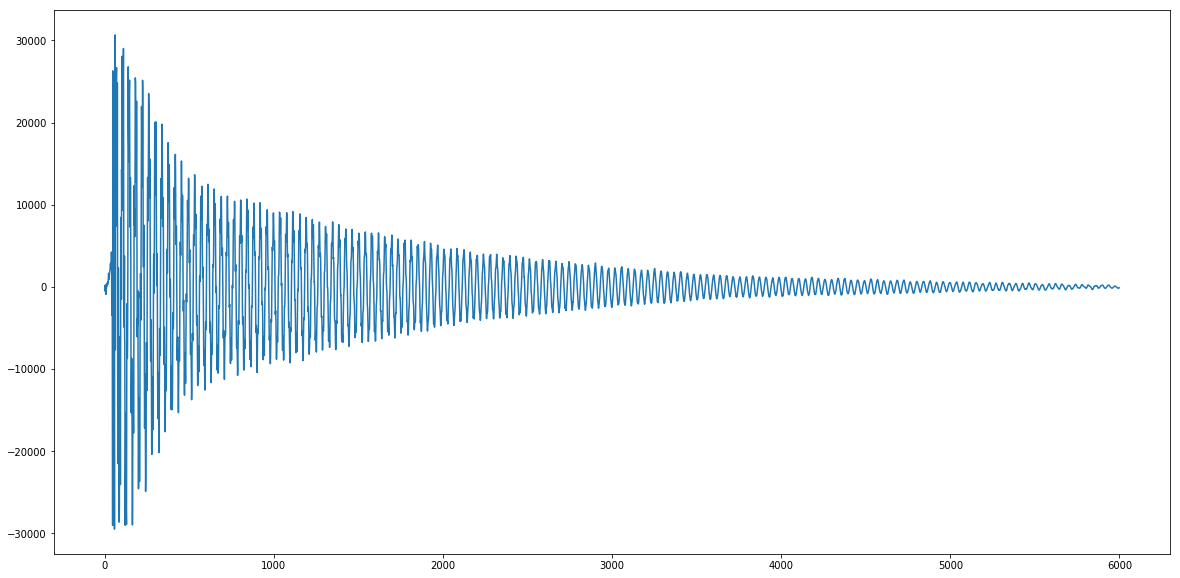

In [5]:
plt.plot(garrafa)

#### Definição do ruído de leitura

In [6]:
var_ruido_leitura = 0.01
std_ruido_leitura = np.sqrt(var_ruido_leitura)
ruido_leitura = np.random.normal(0, std_ruido_leitura, samples_ruido)

####  Definição do ruído de excitação

In [7]:
ruido_excitacao = np.random.normal(0, 1, samples_ruido)

#### A resposta ao ruído de excitação

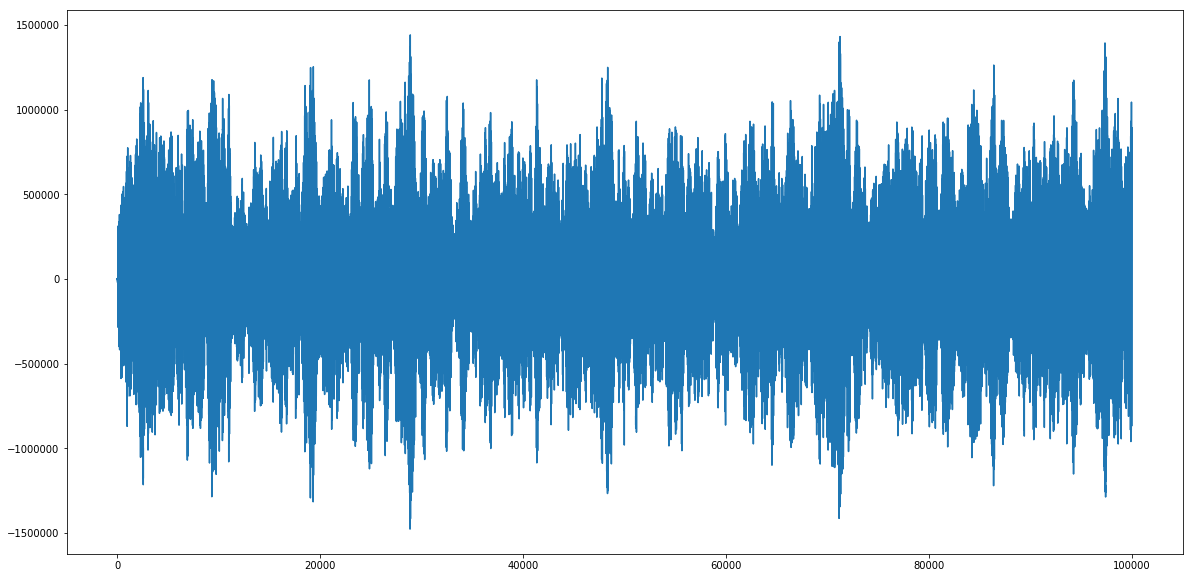

In [8]:
resposta = np.convolve(ruido_excitacao, garrafa)[:samples_ruido] + ruido_leitura 
plt.plot(resposta)

In [9]:
def erro(resposta, estimado):
    assert resposta.shape == estimado.shape, "Os dois vetores precisam ter o mesmo tamanho."
    
    vetor_erro_bruto = np.square(resposta - estimado)
    erro_bruto = vetor_erro_bruto.sum()
    
    vetor_normalizacao = np.square(resposta)
    normalizacao = vetor_normalizacao.sum()
    
    return erro_bruto / normalizacao

## 2. Estimador por Correlação
Queremos mostrar que $ \rho[k] = \frac{1}{K} \sum_{m=0}^{K} r[m]w[k-m] \approx \frac{h[k]}{K} \Rightarrow \sum_{m=0}^{K} r[m]w[k-m] \approx h[k]$ pode ser obtido a partir da passagem do sinal $r[k] = w[k] * h[k] + n[k]$ por um filtro de resposta ao impulso $w[-k]$.

Partindo da resposta desse filtro: 
$$x[k] = r[k] * w[-k] $$
Fazendo $z[k] = g[-k]$, temos:
$$x[k] = \sum_{j=0}^{K} r[m] z[k-m] = \sum_{j=0}^{K} r[m] w[m-k]$$
$$\rho[k] \triangleq \frac{1}{K} \sum_{j=0}^{K} r[m] w[m-k] \square$$

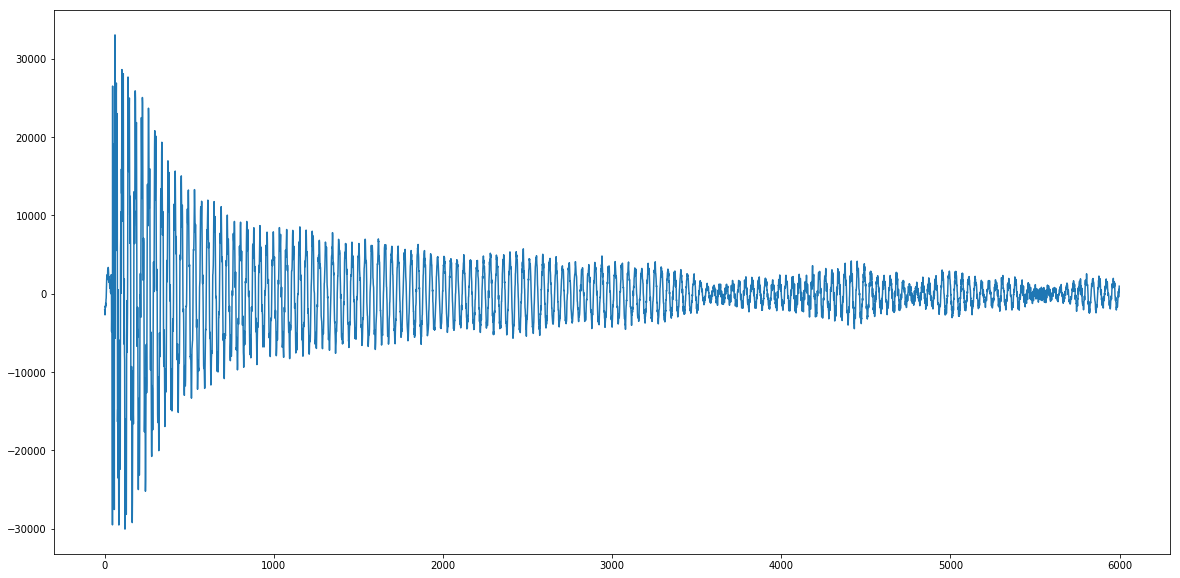

In [10]:
estimativa_correlacao_simples = np.correlate(resposta, ruido_excitacao, mode='full') / samples_ruido
plt.plot(estimativa_correlacao_simples[samples_ruido:samples_ruido + M - 1])

In [11]:
erro_correlacao_simples = erro(garrafa, estimativa_correlacao_simples[samples_ruido:samples_ruido + M])

In [12]:
erro_correlacao_simples

0.2561077768062619

## 3. Estimador com média de correlação
$$x[k] = r[k] * w[-k] = w[k] * w[-k] * h[k] + n[k] * w[-k] \Rightarrow$$
$$X(f) = K \mathscr{F}(\rho[k]) = W(f) W^*(f) H(f) + N(f) W^*(f) \Rightarrow$$
$$P(f) = \frac{|W(f)|^2 H(f) + N(f) W^*(f)}{K} \Rightarrow$$
$$E[P(f)] = E[\frac{|W(f)|^2 H(f) + N(f) W^*(f)}{K}]$$
$$= \frac{1}{K} (E[|W(f)|^2 H(f)] + E[N(f) W^*(f)])$$
$$= \frac{1}{K} (E[|W(f)|^2] E[H(f)] + E[N(f)] E[W^*(f)])$$
$$= \frac{1}{K} E[H(f)] \square$$

In [13]:
def experimento_com_repeticoes(experimento, num_realizacoes, resp_impulso, std_ruido):
    estimativa = 0
    for i in range(num_realizacoes):
        pho = experimento(resp_impulso, std_ruido)
        estimativa += pho

    return estimativa / num_realizacoes # Média entre realizações para cada posição

In [14]:
def estimativa_correlacao(resp_impulso, std_ruido):
    ruido_leitura = np.random.normal(0, std_ruido, samples_ruido)
    ruido_excitacao = np.random.normal(0, 1, samples_ruido)
    resultado = np.convolve(ruido_excitacao, resp_impulso)[:samples_ruido] + ruido_leitura
    
    estimativa = np.correlate(resultado, ruido_excitacao, 'full') / samples_ruido
    return estimativa

In [15]:
estimativa_pela_media = experimento_com_repeticoes(estimativa_correlacao, num_realizacoes, garrafa, std_ruido_leitura)

In [16]:
erro_media = erro(garrafa, estimativa_pela_media[samples_ruido:samples_ruido + M])

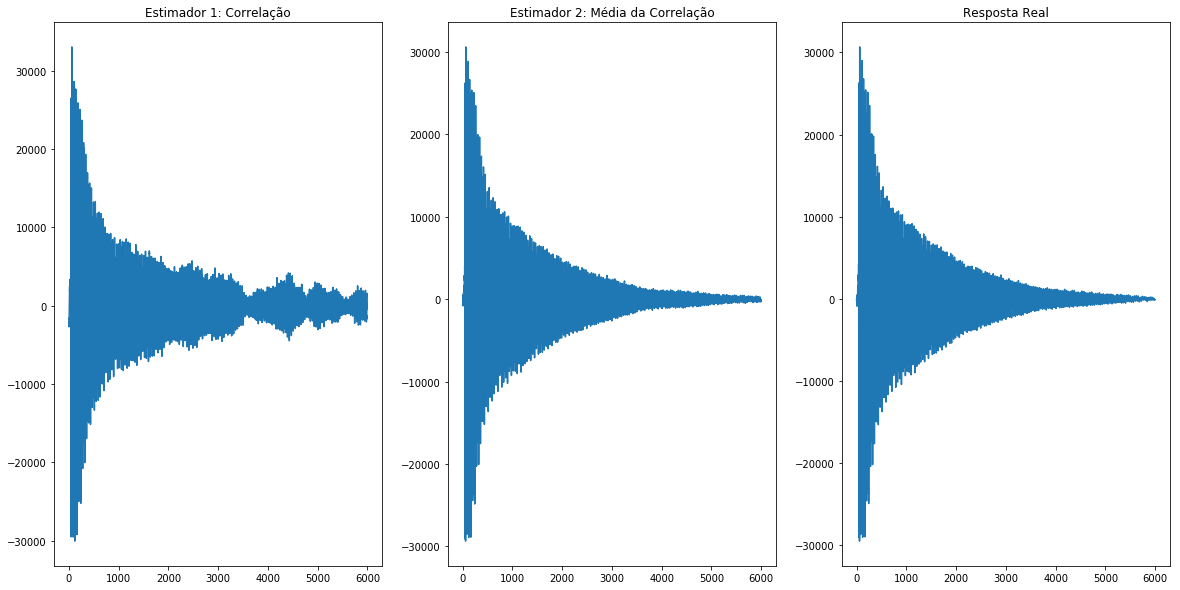

In [79]:
plt.subplot(131)
plt.title('Estimador 1: Correlação')
plt.plot(estimativa_correlacao_simples[samples_ruido:samples_ruido + M])

plt.subplot(132)
plt.title('Estimador 2: Média da Correlação')
plt.plot(estimativa_pela_media[samples_ruido:samples_ruido + M])

plt.subplot(133)
plt.title('Resposta Real')
plt.plot(garrafa)

In [18]:
erro_media / erro_correlacao_simples

0.8446865202036324

In [19]:
erro_media

0.21633078678756992

## 4. Mínimo Erro Quadrático Médio
$$r[k] = h[k] * w[k] + n[k] = \sum_{j=0}^{K} h[j] w[k-j] + n[k]$$
$$= \begin{bmatrix}
        h[0] & h[1] & h[2] & \dots & h[K]
    \end{bmatrix}
    \begin{bmatrix}
        w[k] \\
        w[k-1] \\
        w[k-2] \\
        \vdots \\
        w[k-K]
    \end{bmatrix} + n[k]
$$
$$= \begin{bmatrix}
        w[k] & w[k-1] & w[k-2] & \dots & w[k-K]
    \end{bmatrix}
    \begin{bmatrix}
        h[0] \\
        h[1] \\
        h[2] \\
        \vdots \\
        h[K]
    \end{bmatrix} + n[k]
$$
$$\triangleq \mathbf{W}^T[k] \mathbf{h} + N[k]$$

Aqui, a matriz $\mathbf{W^T}$ é definida como uma matriz cujas colunas têm o formato 
$$\begin{bmatrix} \dots \begin{bmatrix}
      w[k] \\
      w[k-1] \\
      w[k-2] \\
      \vdots \\
      w[k-K]
  \end{bmatrix} \dots \end{bmatrix}
  \forall k \in \mathbb{N} | 0 \leq k \leq M
$$
Onde M é a quantidade de amostras do ruído a ser usadas no processo de estimação.
O número de colunas K da matriz $\mathbf{W}$ é determinado pelo número de amostras da
resposta ao impulso. O vetor $\mathbf{h}$ é um vetor coluna contendo as amostras da resposta
ao impulso, e o vetor N é um vetor coluna contendo as amostras do ruído de leitura.

In [28]:
ruido_leitura = np.random.normal(0, std_ruido_leitura, samples_ruido)
ruido_excitacao = np.random.normal(0, 1, samples_ruido)
resposta = np.convolve(ruido_excitacao, garrafa)[:samples_ruido] + ruido_leitura

In [71]:
auto_corr = np.correlate(ruido_excitacao, ruido_excitacao, mode='full')[samples_ruido:samples_ruido+M]
noise_response = np.correlate(resposta, ruido_excitacao, 'full')[samples_ruido:samples_ruido+M]

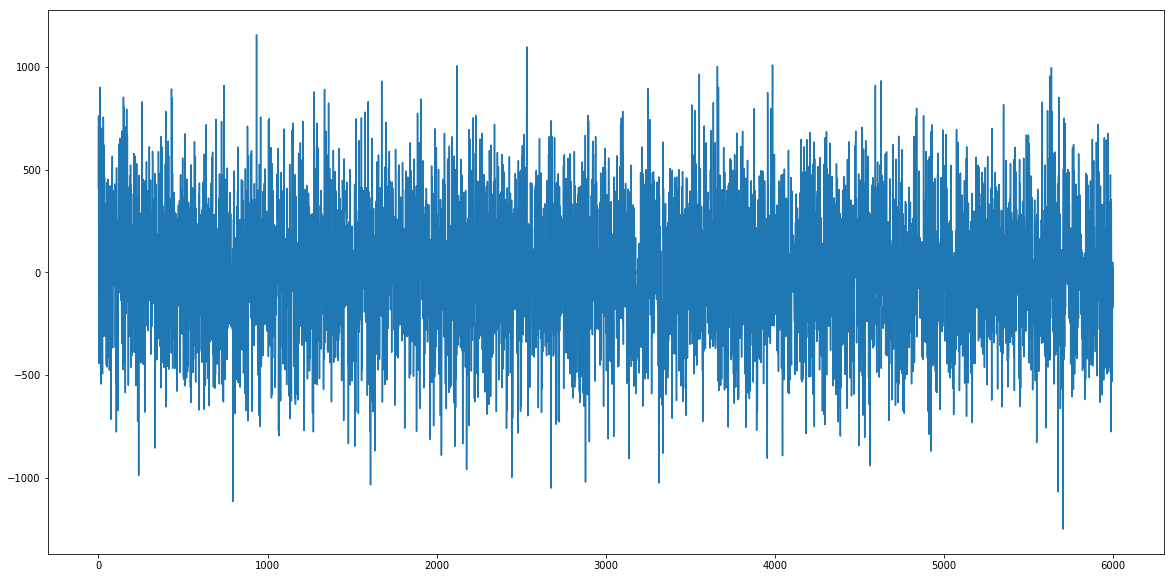

In [72]:
plt.plot(auto_corr)

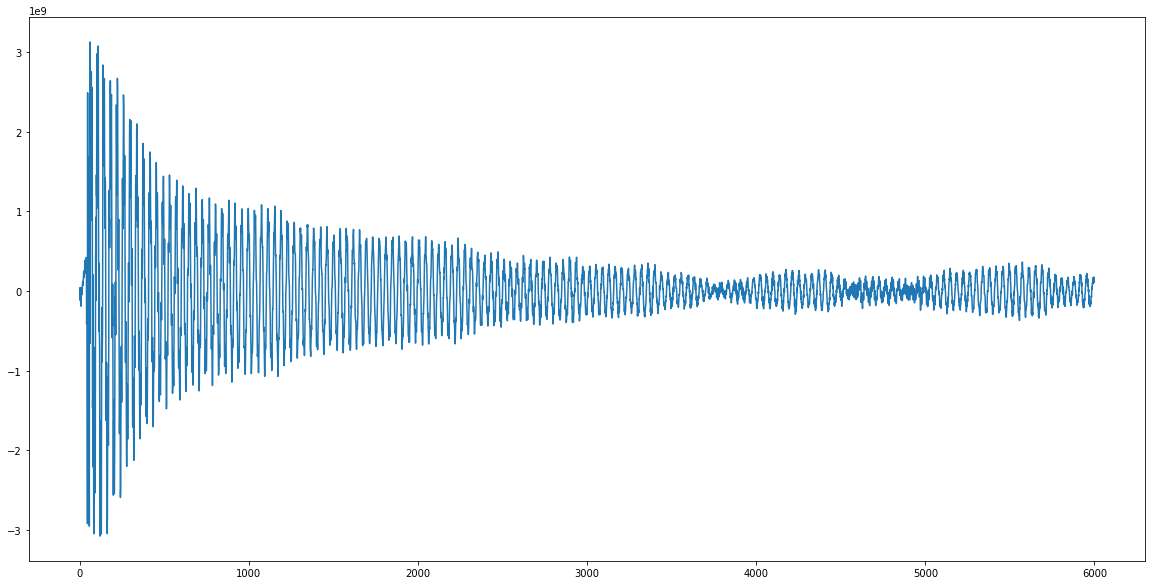

In [74]:
plt.plot(noise_response)

In [75]:
h_corr = solve_toeplitz(auto_corr, noise_response)

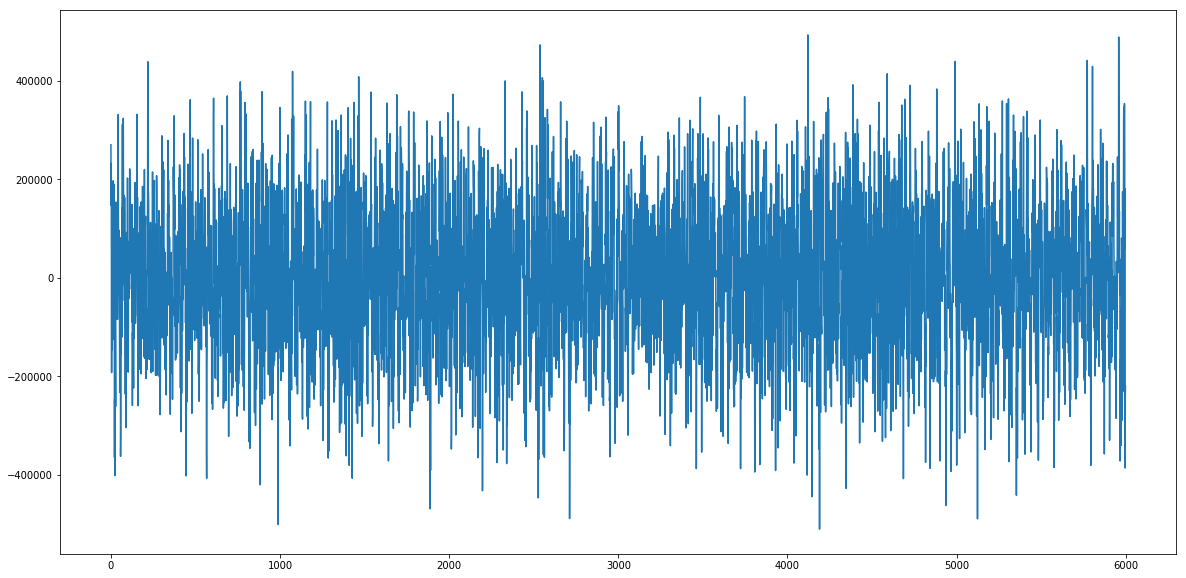

In [77]:
plt.plot(h_corr)

In [ ]:
def estimativa_toeplitz(resposta_impulso, std_ruido):
    ruido_leitura = np.random.normal(0, std_ruido_leitura, resposta_impulso.shape)
    ruido_excitacao = np.random.normal(0, 1, (60000,))
    resposta = np.convolve(ruido_excitacao, resposta_impulso)[-resposta_impulso.shape[0]:] + ruido_leitura
    
    auto_corr = np.correlate(ruido_excitacao, ruido_excitacao, 'full')[-resposta_impulso.shape[0]:]
    corr_resposta_ruido = np.convolve(resposta, ruido_excitacao, 'full')[-resposta_impulso.shape[0]:]
    return solve_toeplitz(auto_corr, corr_resposta_ruido)

In [ ]:
estimativa_por_mse = experimento_com_repeticoes(estimativa_toeplitz, num_realizacoes, garrafa, std_ruido_leitura)

In [ ]:
plt.plot(estimativa_por_mse)

In [ ]:
erro_toeplitz = erro(garrafa, estimativa_por_mse)

In [ ]:
erro_toeplitz / erro_media

In [ ]:
erro_toeplitz / erro_correlacao